# Librerias a usar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# model libraries
import gluonts
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.trainer import Trainer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error

from mxnet import gpu
import mxnet as mx


c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.17.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Importar Dataset

In [7]:
df_dies = pd.read_csv('new_df_dies.csv').set_index('CMPLNT_FR_DT')
filtered_df = pd.read_csv('df_filtered.csv')
df_crimes = pd.read_csv('df_crimes.csv')

In [8]:
df_dies.index = pd.to_datetime(df_dies.index)

In [9]:
df_dies

,Agressions,New Years,agressions_lag_1,agressions_lag_2,agressions_lag_3,agressions_lag_4,agressions_week_avg,agressions_biweek_avg,agressions_1_month_avg,agressions_2_month_avg,...,"cos(2,freq=M)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",Poverty,Unemployment,Bachelor_or_higher
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2000-01-01,73.0,1,0.0,0.0,0.0,1.0,10.571429,5.285714,2.766667,1.883333,...,1.000000,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,0.212,0.096,0.274
2000-01-02,0.0,0,73.0,0.0,0.0,0.0,10.571429,5.285714,2.766667,1.866667,...,0.918958,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,0.212,0.096,0.274
2000-01-04,0.0,0,0.0,73.0,0.0,0.0,10.571429,5.285714,2.766667,1.850000,...,0.347305,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,0.212,0.096,0.274
2000-01-05,1.0,0,0.0,0.0,73.0,0.0,10.571429,5.357143,2.766667,1.850000,...,-0.050649,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,0.212,0.096,0.274
2000-01-07,0.0,0,1.0,0.0,0.0,73.0,10.571429,5.357143,2.766667,1.850000,...,-0.758758,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,0.212,0.096,0.274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,19.0,0,25.0,21.0,17.0,21.0,19.857143,20.428571,20.966667,20.866667,...,-0.440394,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,0.192,0.078,0.321
2018-12-28,22.0,0,19.0,25.0,21.0,17.0,20.714286,20.142857,21.133333,20.950000,...,-0.050649,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,0.192,0.078,0.321
2018-12-29,25.0,0,22.0,19.0,25.0,21.0,21.428571,19.928571,21.266667,20.966667,...,0.347305,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,0.192,0.078,0.321


# Configuración previa

In [10]:
fechas_principales ={
    'fecha_inicio_train': '2001-01-01',
    'fecha_final_train': '2018-06-30',
    'fecha_inicio_test': '2018-07-01',
    'fecha_final_test': '2018-08-31'
}

In [11]:
df_dies.keys()

Index(['Agressions', 'New Years', 'agressions_lag_1', 'agressions_lag_2',
       'agressions_lag_3', 'agressions_lag_4', 'agressions_week_avg',
       'agressions_biweek_avg', 'agressions_1_month_avg',
       'agressions_2_month_avg',
       ...
       'cos(2,freq=M)', 'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)',
       'sin(2,freq=W-SUN)', 'cos(2,freq=W-SUN)', 'sin(3,freq=W-SUN)',
       'cos(3,freq=W-SUN)', 'Poverty', 'Unemployment', 'Bachelor_or_higher'],
      dtype='object', length=136)

# Funciones necesarias para separar por categorias

In [12]:
def add_header_keys(df, keys, header):
    map_ = {k: header + k for k in keys}
    return df.rename(columns=map_)


def split_dynamic_stat_data(df, keys=None, thresh=0.05):
    if keys is None:
        keys = [k for k in df.keys() if k not in ['Agressions', 'code', 'ds']]
    dynamic = []
    unique_codes = np.unique(df.index)
    limit = int(thresh * len(unique_codes))
    counts = {k: [] for k in keys}
    for k in keys:
        if len(np.unique(df[k])) > limit:
                dynamic.append(k)
                keys.remove(k)
    static = [k for k in keys]

    return dynamic, static



def split_real_categorical_data(df, thresh=0.1, keys=[], isdynamical=True, auto=False):

    if len(keys) == 0 and auto:
        keys = [k for k in df.keys() if k not in ['Agressions', 'code', 'ds']]
    elif len(keys) == 0:
        return [], []

    if isdynamical:
        """
        this will not work for statical data... but it is the most pure way to do it.
        """
        votes = {k: 0 for k in keys}
        for k in keys:
            if len(df[k]) > 1:
                if len(np.unique(df[k])) < thresh * len(df[k]) or len(np.unique(df[k])) == 1:
                    votes[k] -= 1
                else:
                    votes[k] += 1.5

        categorical = []
        real = []
        for k in votes.keys():
            if votes[k] >= 0:
                real.append(k)
            else:
                categorical.append(k)

    else:
        categorical = []
        for k in keys:
            if len(np.unique(df[k])) < thresh * len(df):
                categorical.append(k)
                keys.remove(k)
        real = keys

    print(f'Real keys before formatting {real}')
    print(f'Categorical keys before formatting {categorical}')
    print()
    for k in real:
        if isinstance(np.array(df[k])[0], str):
            categorical.append(k)
            real.remove(k)
    for k in categorical:
        if isinstance(np.array(df[k])[0], float):
            real.append(k)
            categorical.remove(k)
    print(f'Real keys after formatting {real}')
    print(f'Categorical keys after formatting {categorical}')
    return categorical, real

def split_features(df, thresh=0.1):
    dyn, stat = split_dynamic_stat_data(df)
    dyn_cat, dyn_re = split_real_categorical_data(df, thresh=thresh, keys=dyn)
    stat_cat, stat_re = split_real_categorical_data(df, thresh=thresh, keys=stat)
    return dyn_cat, dyn_re, stat_cat, stat_re

def generate_labelled_exogenous_df(df, one_hot=True, thresh=0.1,ignore_keys = [['Agressions']]):
    df = df.fillna(0)
    dyn_cat, dyn_re, stat_cat, stat_re = split_features(df, thresh=thresh)
    print('Dynamical categorical features:')
    for k in dyn_cat:
        print(k)
    print('\n\n')
    print('Dynamical real features:')
    for k in dyn_re:
        print(k)
    print('\n\n')
    print('Statical categorical features:')
    for k in stat_cat:
        print(k)
    print('\n\n')
    print('Statical real features:')
    for k in stat_re:
        print(k)
    print('\n\n')
    new_df = df.copy()
    new_df = add_header_keys(new_df, dyn_cat, 'dyn_cat_')
    new_df = add_header_keys(new_df, dyn_re, 'dyn_re_')
    new_df = add_header_keys(new_df, stat_cat, 'stat_cat_')
    new_df = add_header_keys(new_df, stat_re, 'stat_re_')

    ordinal_encoder = None

    if one_hot:
        cat_dyn_keys = [k for k in new_df.keys() if 'dyn_cat_' in k]
        for k in cat_dyn_keys:
            tmp = pd.get_dummies(new_df[k], prefix=k)
            for new_k in tmp.keys():
                new_k_re = new_k.replace('dyn_cat_', 'dyn_re_OneHot_')
                new_df[new_k_re] = tmp[new_k].copy()
        new_df = new_df.drop(cat_dyn_keys, axis=1)

        cat_sat_keys = [k for k in new_df.keys() if 'stat_cat_' in k]
        features = new_df[cat_sat_keys].to_numpy()
        ordinal_encoder = OrdinalEncoder().fit(features)
        encoded_features = ordinal_encoder.transform(features)
        for i, k in enumerate(cat_sat_keys):
            new_df[k] = encoded_features[:, i]

    return new_df, ordinal_encoder

In [13]:
df, encod = generate_labelled_exogenous_df(df_dies, one_hot = False)

Real keys before formatting ['agressions_week_avg', 'agressions_1_month_avg', 'trend', 'cos(1,freq=A-DEC)', 'cos(2,freq=A-DEC)', 'cos(3,freq=A-DEC)', 'cos(4,freq=A-DEC)', 'cos(5,freq=A-DEC)']
Categorical keys before formatting ['cos(1,freq=M)', 'cos(2,freq=M)']

Real keys after formatting ['agressions_week_avg', 'agressions_1_month_avg', 'trend', 'cos(1,freq=A-DEC)', 'cos(2,freq=A-DEC)', 'cos(3,freq=A-DEC)', 'cos(4,freq=A-DEC)', 'cos(5,freq=A-DEC)', 'cos(1,freq=M)']
Categorical keys after formatting ['cos(2,freq=M)']
Real keys before formatting ['agressions_biweek_avg', 'agressions_2_month_avg', 'sin(1,freq=A-DEC)', 'sin(2,freq=A-DEC)', 'sin(3,freq=A-DEC)', 'sin(4,freq=A-DEC)', 'sin(5,freq=A-DEC)']
Categorical keys before formatting ['New Years', 'agressions_lag_1', 'agressions_lag_2', 'agressions_lag_3', 'agressions_lag_4', 'month', 'primavera', 'estiu', 'tardor', 'hivern', 'year_1905', 'year_1906', 'year_1908', 'year_1909', 'year_1910', 'year_1911', 'year_1912', 'year_1913', 'year_19

In [14]:
df

,Agressions,stat_cat_New Years,stat_re_agressions_lag_1,stat_cat_agressions_lag_2,stat_re_agressions_lag_3,stat_cat_agressions_lag_4,dyn_re_agressions_week_avg,stat_re_agressions_biweek_avg,dyn_re_agressions_1_month_avg,stat_re_agressions_2_month_avg,...,"dyn_cat_cos(2,freq=M)","stat_re_sin(1,freq=W-SUN)","stat_cat_cos(1,freq=W-SUN)","stat_re_sin(2,freq=W-SUN)","stat_cat_cos(2,freq=W-SUN)","stat_re_sin(3,freq=W-SUN)","stat_cat_cos(3,freq=W-SUN)",stat_re_Poverty,stat_cat_Unemployment,stat_re_Bachelor_or_higher
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2000-01-01,73.0,1,0.0,0.0,0.0,1.0,10.571429,5.285714,2.766667,1.883333,...,1.000000,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,0.212,0.096,0.274
2000-01-02,0.0,0,73.0,0.0,0.0,0.0,10.571429,5.285714,2.766667,1.866667,...,0.918958,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,0.212,0.096,0.274
2000-01-04,0.0,0,0.0,73.0,0.0,0.0,10.571429,5.285714,2.766667,1.850000,...,0.347305,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,0.212,0.096,0.274
2000-01-05,1.0,0,0.0,0.0,73.0,0.0,10.571429,5.357143,2.766667,1.850000,...,-0.050649,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,0.212,0.096,0.274
2000-01-07,0.0,0,1.0,0.0,0.0,73.0,10.571429,5.357143,2.766667,1.850000,...,-0.758758,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,0.212,0.096,0.274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,19.0,0,25.0,21.0,17.0,21.0,19.857143,20.428571,20.966667,20.866667,...,-0.440394,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,0.192,0.078,0.321
2018-12-28,22.0,0,19.0,25.0,21.0,17.0,20.714286,20.142857,21.133333,20.950000,...,-0.050649,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,0.192,0.078,0.321
2018-12-29,25.0,0,22.0,19.0,25.0,21.0,21.428571,19.928571,21.266667,20.966667,...,0.347305,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,0.192,0.078,0.321


In [15]:
cols_dyn_re = df.columns[df.columns.str.match(r'dyn_re')]
cols_stat_cat = df.columns[df.columns.str.match(r'stat_cat')]
cols_dyn_cat = df.columns[df.columns.str.match(r'dyn_cat')]
cols_stat_re = df.columns[df.columns.str.match(r'stat_re')]

In [16]:
len(cols_dyn_re),len(cols_stat_cat),len(cols_dyn_cat),len(cols_stat_re)

(9, 110, 1, 15)

In [17]:
cols_dyn_re = cols_dyn_re.tolist() + cols_dyn_cat.tolist()

In [18]:
cols_stat_cat.tolist()

['stat_cat_New Years',
 'stat_cat_agressions_lag_2',
 'stat_cat_agressions_lag_4',
 'stat_cat_month',
 'stat_cat_primavera',
 'stat_cat_estiu',
 'stat_cat_tardor',
 'stat_cat_hivern',
 'stat_cat_year_1905',
 'stat_cat_year_1906',
 'stat_cat_year_1908',
 'stat_cat_year_1909',
 'stat_cat_year_1910',
 'stat_cat_year_1911',
 'stat_cat_year_1912',
 'stat_cat_year_1913',
 'stat_cat_year_1914',
 'stat_cat_year_1915',
 'stat_cat_year_1916',
 'stat_cat_year_1917',
 'stat_cat_year_1918',
 'stat_cat_year_1919',
 'stat_cat_year_1920',
 'stat_cat_year_1922',
 'stat_cat_year_1928',
 'stat_cat_year_1929',
 'stat_cat_year_1930',
 'stat_cat_year_1938',
 'stat_cat_year_1940',
 'stat_cat_year_1941',
 'stat_cat_year_1942',
 'stat_cat_year_1945',
 'stat_cat_year_1946',
 'stat_cat_year_1947',
 'stat_cat_year_1948',
 'stat_cat_year_1949',
 'stat_cat_year_1950',
 'stat_cat_year_1951',
 'stat_cat_year_1954',
 'stat_cat_year_1955',
 'stat_cat_year_1956',
 'stat_cat_year_1957',
 'stat_cat_year_1958',
 'stat_cat_

In [19]:
cardinality = df[cols_stat_cat.tolist()].max()+1

In [20]:
cardinality = cardinality.astype(int).tolist()

In [21]:
mx.random.seed(7)
np.random.seed(7)

# DeepAR

In [24]:
class DeepAR() : 
    
    #constructor of the class
    def __init__(self,df) : 
        self.df = df
    
    #preparar dataset
    def prepare_dataset_grouped(self, start_index, target_index, target, freq, dyn_re_list, stat_cat_list, stat_re_list):
            
        target_data = self.df[target][start_index:target_index]
        
        dynre_list = [self.df[dyn_re][start_index:target_index] for dyn_re in dyn_re_list]
        statcat_list = [self.df[stat_cat].iloc[0] for stat_cat in stat_cat_list]
        statre_list = [self.df[stat_re].iloc[0] for stat_re in stat_re_list]

        current_dataset = {
            "start": start_index,
            "target": target_data,
            FieldName.FEAT_STATIC_CAT: statcat_list,
            FieldName.FEAT_DYNAMIC_REAL: dynre_list,
            FieldName.FEAT_STATIC_REAL: statre_list
        }

        dataset = ListDataset([current_dataset], freq=freq)
        return dataset 
    
    # preparamos los datos para el la parte del train como la parte del test.
    def prepare_data(self, start_index, target_index, target, freq, dyn_re_list, stat_cat_list, stat_re_list, is_training=True):
        if is_training:
            self.training_data = self.prepare_dataset_grouped(start_index, target_index, target, freq, dyn_re_list, stat_cat_list, stat_re_list)
        else:
            self.test_data = self.prepare_dataset_grouped(start_index, target_index, target, freq, dyn_re_list, stat_cat_list, stat_re_list)

       
    # establecer el estimador de DeepAR
    def estimator (self,freq,context_length,prediction_length,num_layers,num_cells,cell_type,epochs,cardinality, use_external = True) : 
        
        self.estimator = DeepAREstimator(freq=freq, 
                                context_length=context_length,  
                                prediction_length=prediction_length,
                                num_layers=num_layers,    
                                num_cells=num_cells,
                                cell_type=cell_type, 
                                trainer=Trainer(epochs=epochs),
                                use_feat_dynamic_real=True*use_external,
                                use_feat_static_cat=True*use_external,
                                use_feat_static_real=True*use_external,
                                distr_output = NegativeBinomialOutput(),
                                cardinality = cardinality) 

        self.prediction_length = prediction_length

    # entrenamos modelo
    def fit(self) : 
        self.predictor = self.estimator.train(training_data=self.training_data)

    #evaluar modelo
    def evaluate (self,num_samples=100) : 
        forecast_it, ts_it = make_evaluation_predictions(
        dataset=self.test_data,  
        predictor=self.predictor,   
        num_samples=num_samples, 
        )
        self.forecasts = list(forecast_it)
        self.tss =  list(ts_it)

         

In [52]:
deepar = DeepAR(df)
deepar.prepare_data(fechas_principales['fecha_inicio_train'],fechas_principales['fecha_final_train'],'Agressions','d', cols_dyn_re, cols_stat_cat, cols_stat_re,is_training=True)

cardinality = np.array(df[cols_stat_cat].max()+1)

deepar.estimator(freq = 'd',context_length = 40, prediction_length = 61, num_layers = 4, num_cells = 40,cell_type = "gru",epochs = 50,cardinality = cardinality.tolist())
deepar.fit()

deepar.prepare_data(fechas_principales['fecha_inicio_test'],fechas_principales['fecha_final_test'],'Agressions','d', cols_dyn_re, cols_stat_cat, cols_stat_re,is_training=False)
deepar.evaluate(num_samples=100)

100%|██████████| 50/50 [00:14<00:00,  3.44it/s, epoch=50/50, avg_epoch_loss=3.52]


In [53]:
y_pred = deepar.forecasts[0].samples.mean(axis = 0)
y_real = np.array(deepar.tss[0]).reshape(-1)[1:]

In [54]:
df_test = pd.DataFrame()
f = filtered_df.groupby(filtered_df.CMPLNT_FR_DT).size()

In [55]:
fecha_inicio_test = '2018-07-01'
fecha_final_test = '2018-08-31'

df_test['Agressions'] = f.loc[fecha_inicio_test:fecha_final_test].to_frame()

In [56]:
df_test

,Agressions
CMPLNT_FR_DT,
2018-07-01,86
2018-07-02,20
2018-07-03,25
2018-07-04,29
2018-07-05,26
...,...
2018-08-27,24
2018-08-28,16
2018-08-29,22


In [57]:
len(y_pred)

61

In [58]:
# Eliminar la última fila
df_test = df_test.drop(df_test.index[0])

In [59]:
df_test['Pred'] = y_pred
test = df_test

In [60]:
def sqr_err(y_true, y_pred):
    """

    :param y_true: true values of y
    :param y_pred: predicted values of y
    :return: array of lenght original data containing mean squared error for each predictions
    """
    if len(y_true) != len(y_pred):
        raise IndexError("Mismathced array sizes, you inputted arrays with sizes {} and {}".format(len(y_true),
                                                                                                  len(y_pred)))
    else:
        length = len(y_true)

    sqrerror_out = [(y_pred[i]-y_true[i])**2 for i in range(length)]

    return np.array(sqrerror_out)

In [61]:
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = sqr_err(test['Agressions'], test['Pred'])
test

,Agressions,Pred,Mean model,MAPE,MAPE mean,SMAPE,SMAPE mean,MAE,MAE mean,Metrica nomb,Metrica nomb mean,RMSE,RMSE mean,MSE
CMPLNT_FR_DT,,,,,,,,,,,,,,
2018-07-02,20,14.250000,23.47541,22.475544,20.738455,23.746233,20.686895,5.623115,4.842247,40.983607,54.098361,8.731547,7.843984,33.062500
2018-07-03,25,21.840000,23.47541,22.475544,20.738455,23.746233,20.686895,5.623115,4.842247,40.983607,54.098361,8.731547,7.843984,9.985599
2018-07-04,29,14.260000,23.47541,22.475544,20.738455,23.746233,20.686895,5.623115,4.842247,40.983607,54.098361,8.731547,7.843984,217.267593
2018-07-05,26,13.520000,23.47541,22.475544,20.738455,23.746233,20.686895,5.623115,4.842247,40.983607,54.098361,8.731547,7.843984,155.750389
2018-07-06,24,13.420000,23.47541,22.475544,20.738455,23.746233,20.686895,5.623115,4.842247,40.983607,54.098361,8.731547,7.843984,111.936398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-27,24,18.709999,23.47541,22.475544,20.738455,23.746233,20.686895,5.623115,4.842247,40.983607,54.098361,8.731547,7.843984,27.984110
2018-08-28,16,20.340000,23.47541,22.475544,20.738455,23.746233,20.686895,5.623115,4.842247,40.983607,54.098361,8.731547,7.843984,18.835601
2018-08-29,22,20.280001,23.47541,22.475544,20.738455,23.746233,20.686895,5.623115,4.842247,40.983607,54.098361,8.731547,7.843984,2.958398


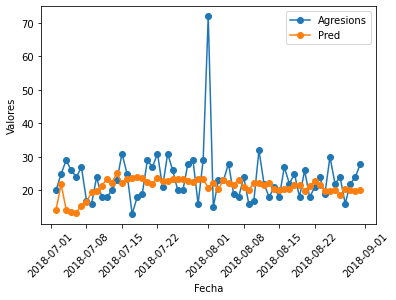

In [62]:
# Convertir el índice a tipo datetime si aún no lo es
test.index = pd.to_datetime(test.index)

# Crear una gráfica de líneas con las columnas 'Agresions' y 'Pred'
plt.plot(test.index, test['Agressions'], label='Agresions', marker='o')
plt.plot(test.index, test['Pred'], label='Pred', marker='o')

# Añadir etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.legend()

# Rotar las fechas en el eje x para mejorar la legibilidad
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

In [63]:
pred_ver_deepar = test[['Agressions','Pred']]
pred_ver_deepar

,Agressions,Pred
CMPLNT_FR_DT,,
2018-07-02,20,14.250000
2018-07-03,25,21.840000
2018-07-04,29,14.260000
2018-07-05,26,13.520000
2018-07-06,24,13.420000
...,...,...
2018-08-27,24,18.709999
2018-08-28,16,20.340000
2018-08-29,22,20.280001


In [64]:
pred_ver_deepar.to_csv("pred_models_verano_2018_deepar_ny.csv")